In [1]:
%load_ext autoreload
%autoreload 2

In [74]:
import pandas as pd
import numpy as np
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model
from sklearn.utils import class_weight
from collections import defaultdict
import matplotlib.pyplot as plt
import pickle

from src.embeddings import get_embedding_dictionnary, get_embeddings_and_word_index, sequences_to_index
from src.dataset import load_dataset, load_datasets_and_vocab_pipeline, train_test_val_split
from src.evaluate import get_metrics, get_predictions, compare_metrics
from src.models import model_mine
from src.submission import generate_predictions
from src.model_saverloader import save_model_full, load_model_full, load_best_metrics

embeddings_path = '../sentiment_analysis/data/embeddings/datastories.twitter.300d.txt'

### Load and preprocess Train and Test

In [3]:
(X_train, y_train), (X_test, y_test), (vocab, max_seq_len) = load_datasets_and_vocab_pipeline()

Reading twitter - 1grams ...
Reading twitter - 2grams ...


Preprocessing...:   0%|          | 0/30160 [00:00<?, ?it/s]

Reading twitter - 1grams ...


Building vocabulary...: 100%|██████████| 32915/32915 [00:00<00:00, 165836.64it/s]


In [4]:
X_train.shape, X_train.values.shape, X_test.shape, y_test.values.shape

((30160,), (30160,), (2755,), (2755,))

### Check sequences lengths

In [8]:
lenghts = [len(x) for x in X_train]
lenghts += [len(x) for x in X_test]

In [9]:
len(lenghts)

32915

(array([2.3686e+04, 8.6050e+03, 5.4600e+02, 6.7000e+01, 6.0000e+00,
        2.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  5. ,  20.8,  36.6,  52.4,  68.2,  84. ,  99.8, 115.6, 131.4,
        147.2, 163. ]),
 <a list of 10 Patch objects>)

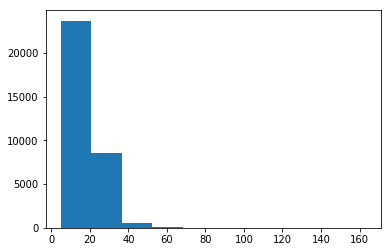

In [16]:
plt.hist(lenghts)

In [22]:
len([l for l in lenghts if l > 80])

6

In [12]:
sorted(lenghts, reverse=True)[:30]

[163,
 143,
 118,
 87,
 85,
 81,
 79,
 77,
 75,
 74,
 74,
 68,
 68,
 68,
 67,
 67,
 67,
 66,
 66,
 66,
 66,
 66,
 65,
 65,
 65,
 65,
 65,
 64,
 64,
 64]

### Compute the classes weights because our dataset is largely unbalanced

In [43]:
cls_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
cls_weights

array([1.36941518, 1.77704454, 1.38019403, 0.50441531])

In [56]:
cls_weights_tst = class_weight.compute_class_weight('balanced', np.unique(y_test), y_test)
cls_weights_tst

array([4.59166667, 4.85035211, 5.51      , 0.29458939])

### Create an embedding matrix for our vocabulary

In [7]:
emb_matrix, word_index, unknown_words = get_embeddings_and_word_index(embeddings_path, max_seq_len, vocab)
# Unknown words: 1300

print(f'Unknown words from the vocabulary: {len(unknown_words)} (previously 1300 without spellcheck fixes)')
print(f'{len(unknown_words) / len(vocab) * 100:.2f}% of our vocabulary are unknown words to the embedding matrix')

Unknown words from the vocabulary: 507 (previously 1300 without spellcheck fixes)
3.44% of our vocabulary are unknown words to the embedding matrix


### Transforming our sequences of words to indexes

In [12]:
X_train = sequences_to_index(X_train, word_index, max_seq_len)
X_test = sequences_to_index(X_test, word_index, max_seq_len)

X_train.shape, X_test.shape

((30160, 163), (2755, 163))

In [13]:
y_train = to_categorical(y_train, 4) if len(y_train.shape) == 1 else y_train
y_test = to_categorical(y_test, 4) if len(y_test.shape) == 1 else y_test
(x_trn, y_trn), (x_val, y_val) = train_test_val_split(X_train, y_train)

print('training set: ' + str(len(x_trn)) + ' samples')
print('validation set: ' + str(len(x_val)) + ' samples')

print('x_train:', x_trn.shape)
print('y_train:', y_trn.shape)

training set: 21111 samples
validation set: 9049 samples
x_train: (21111, 163)
y_train: (21111, 4)


### Training

In [39]:
model = model_mine(emb_matrix, max_seq_len)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_layer (Embedding)  (None, 163, 300)          4424100   
_________________________________________________________________
dropout_1 (Dropout)          (None, 163, 300)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 163, 300)          541200    
_________________________________________________________________
dropout_2 (Dropout)          (None, 163, 300)          0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 163, 300)          541200    
_________________________________________________________________
dropout_3 (Dropout)          (None, 163, 300)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 48900)             0         
__________

In [40]:
callbacks_list = [
        ModelCheckpoint(filepath='pickles/models/best.h5', save_best_only=True, verbose=1),
        EarlyStopping(patience=3, verbose=0)
    ]

In [44]:
history = model.fit(x_trn, y_trn, batch_size=128, validation_data=(x_val, y_val), epochs=10, class_weight=cls_weights, callbacks=callbacks_list)

Train on 21111 samples, validate on 9049 samples
Epoch 1/10
21111/21111 [==============================] - 384s 18ms/step - loss: 0.7778 - acc: 0.6932 - val_loss: 0.5683 - val_acc: 0.7809

Epoch 00001: val_loss improved from inf to 0.56829, saving model to pickles/models/best.h5
Epoch 2/10
21111/21111 [==============================] - 377s 18ms/step - loss: 0.5163 - acc: 0.8046 - val_loss: 0.4471 - val_acc: 0.8334

Epoch 00002: val_loss improved from 0.56829 to 0.44709, saving model to pickles/models/best.h5
Epoch 3/10
21111/21111 [==============================] - 384s 18ms/step - loss: 0.4321 - acc: 0.8428 - val_loss: 0.3703 - val_acc: 0.8676

Epoch 00003: val_loss improved from 0.44709 to 0.37026, saving model to pickles/models/best.h5
Epoch 4/10
21111/21111 [==============================] - 388s 18ms/step - loss: 0.3760 - acc: 0.8623 - val_loss: 0.3676 - val_acc: 0.8715

Epoch 00004: val_loss improved from 0.37026 to 0.36764, saving model to pickles/models/best.h5
Epoch 5/10
2111

In [64]:
epochs_to_do = 5

initial_ep = model.history.params['epochs']
epochs = epochs_to_do + initial_ep

history2 = model.fit(x_trn, y_trn, batch_size=128, validation_data=(x_val, y_val), epochs=epochs, initial_epoch=initial_ep, class_weight=cls_weights, callbacks=callbacks_list)

Train on 21111 samples, validate on 9049 samples
Epoch 11/15
21111/21111 [==============================] - 391s 19ms/step - loss: 0.1823 - acc: 0.9343 - val_loss: 0.3465 - val_acc: 0.8893

Epoch 00011: val_loss did not improve from 0.30148
Epoch 12/15
21111/21111 [==============================] - 386s 18ms/step - loss: 0.1712 - acc: 0.9370 - val_loss: 0.3332 - val_acc: 0.8968

Epoch 00012: val_loss did not improve from 0.30148
Epoch 13/15
21111/21111 [==============================] - 387s 18ms/step - loss: 0.1563 - acc: 0.9435 - val_loss: 0.3574 - val_acc: 0.8916

Epoch 00013: val_loss did not improve from 0.30148
Epoch 14/15
21111/21111 [==============================] - 385s 18ms/step - loss: 0.1437 - acc: 0.9469 - val_loss: 0.3793 - val_acc: 0.8936

Epoch 00014: val_loss did not improve from 0.30148
Epoch 15/15
21111/21111 [==============================] - 381s 18ms/step - loss: 0.1247 - acc: 0.9544 - val_loss: 0.3988 - val_acc: 0.8906

Epoch 00015: val_loss did not improve from

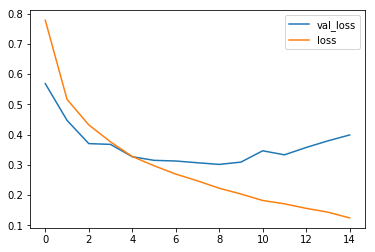

In [65]:
import matplotlib.pyplot as plt


plt.plot(history.epoch + history2.epoch, history.history['val_loss'] + history2.history['val_loss'], label='val_loss')
plt.plot(history.epoch + history2.epoch, history.history['loss'] + history2.history['loss'], label='loss')
plt.legend()

### Training Others vs all

In [79]:
model_bin = model_mine(emb_matrix, max_seq_len, class_number=2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_layer (Embedding)  (None, 163, 300)          4424400   
_________________________________________________________________
dropout_4 (Dropout)          (None, 163, 300)          0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 163, 300)          541200    
_________________________________________________________________
dropout_5 (Dropout)          (None, 163, 300)          0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 163, 300)          541200    
_________________________________________________________________
dropout_6 (Dropout)          (None, 163, 300)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 48900)             0         
__________

In [88]:
binarize = np.vectorize(lambda x: 0 if x in [0, 1, 2] else 1)

y_trn_2 = to_categorical(binarize(y_trn.argmax(axis=1)), 2)
y_val_2 = to_categorical(binarize(y_val.argmax(axis=1)), 2)

In [89]:
callbacks_list_2 = [
        ModelCheckpoint(filepath='pickles/models/best_bin.h5', save_best_only=True, verbose=1),
        EarlyStopping(patience=3, verbose=0)
    ]

In [90]:
history = model_bin.fit(x_trn, y_trn_2, batch_size=128, validation_data=(x_val, y_val_2), epochs=3, callbacks=callbacks_list_2)

Train on 21111 samples, validate on 9049 samples
Epoch 1/3
21111/21111 [==============================] - 419s 20ms/step - loss: 0.5068 - acc: 0.7452 - val_loss: 0.4039 - val_acc: 0.8240

Epoch 00001: val_loss improved from inf to 0.40387, saving model to pickles/models/best_bin.h5
Epoch 2/3
21111/21111 [==============================] - 413s 20ms/step - loss: 0.3873 - acc: 0.8304 - val_loss: 0.3391 - val_acc: 0.8597

Epoch 00002: val_loss improved from 0.40387 to 0.33913, saving model to pickles/models/best_bin.h5
Epoch 3/3
21111/21111 [==============================] - 410s 19ms/step - loss: 0.3323 - acc: 0.8611 - val_loss: 0.3221 - val_acc: 0.8695

Epoch 00003: val_loss improved from 0.33913 to 0.32211, saving model to pickles/models/best_bin.h5


In [92]:
history = model_bin.fit(x_trn, y_trn_2, batch_size=128, validation_data=(x_val, y_val_2), epochs=10, callbacks=callbacks_list_2)

Train on 21111 samples, validate on 9049 samples
Epoch 1/10
21111/21111 [==============================] - 412s 20ms/step - loss: 0.2985 - acc: 0.8794 - val_loss: 0.3039 - val_acc: 0.8853

Epoch 00001: val_loss improved from 0.32211 to 0.30394, saving model to pickles/models/best_bin.h5
Epoch 2/10
21111/21111 [==============================] - 412s 20ms/step - loss: 0.2764 - acc: 0.8892 - val_loss: 0.2682 - val_acc: 0.8946

Epoch 00002: val_loss improved from 0.30394 to 0.26821, saving model to pickles/models/best_bin.h5
Epoch 3/10
21111/21111 [==============================] - 414s 20ms/step - loss: 0.2487 - acc: 0.8996 - val_loss: 0.2698 - val_acc: 0.8971

Epoch 00003: val_loss did not improve from 0.26821
Epoch 4/10
21111/21111 [==============================] - 411s 19ms/step - loss: 0.2297 - acc: 0.9126 - val_loss: 0.2754 - val_acc: 0.8969

Epoch 00004: val_loss did not improve from 0.26821
Epoch 5/10
21111/21111 [==============================] - 409s 19ms/step - loss: 0.2082 - a

### Plot model 4 vs model 2

In [18]:
model_bin = load_model('pickles/models/best_bin.h5')

In [19]:
m_4 = last_best
m_2 = model_bin

preds_4 = m_4.predict(X_test, batch_size=128)
preds_2 = m_2.predict(X_test, batch_size=128)

In [20]:
np.save('pickles/preds/preds_4.npy', preds_4)
np.save('pickles/preds/preds_2.npy', preds_2)

In [21]:
preds_4 = np.load('pickles/preds/preds_4.npy')
preds_2 = np.load('pickles/preds/preds_2.npy')

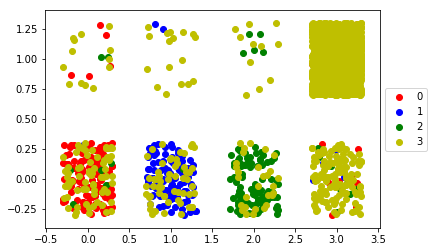

In [32]:
noised_4 = preds_4.argmax(axis=1) + np.random.uniform(low=-0.3, high=0.3, size=len(X_test))
noised_2 = preds_2.argmax(axis=1) + np.random.uniform(low=-0.3, high=0.3, size=len(X_test))

labels = y_test.argmax(axis=1)

unique = np.unique(labels)
colors = ['r', 'b', 'g', 'y']
for i, u in enumerate(unique):
    xi = [noised_4[j] for j  in range(len(noised_4)) if labels[j] == u]
    yi = [noised_2[j] for j  in range(len(noised_2)) if labels[j] == u]
    plt.scatter(xi, yi, c=colors[i], label=str(u))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));

In [45]:
from sklearn.metrics import f1_score

binarize = np.vectorize(lambda x: 0 if x in [0, 1, 2] else 1)

def wrong_others(preds, y_test):
    y_hat = preds.argmax(axis=1)
    if np.max(y_hat) == 3:
        y_hat = binarize(y_hat)
    
    bin_y_test = binarize(y_test.argmax(axis=1))
    
    num_others_preds = len(np.argwhere(y_hat == 1))
    num_others_y_test = len(np.argwhere(bin_y_test == 1))
    
    print(f'{abs(num_others_y_test - num_others_preds)} incorrectly classified others ({num_others_preds} / {num_others_y_test}), f1={f1_score(y_hat, bin_y_test)}')


wrong_others(preds_2, y_test)
wrong_others(preds_4, y_test)

221 incorrectly classified others (2117 / 2338), f1=0.9216610549943883
125 incorrectly classified others (2213 / 2338), f1=0.9408921116238189


In [49]:
combi_preds = np.hstack([preds_4, preds_2])
combi_preds.shape

(2755, 6)

In [63]:
trn_preds_4 = m_4.predict(X_train, batch_size=128)
trn_preds_2 = m_2.predict(X_train, batch_size=128)

In [66]:
np.save('pickles/preds/trn_preds_4.npy', trn_preds_4)
np.save('pickles/preds/trn_preds_2.npy', trn_preds_2)

In [64]:
combi_train_preds = np.hstack([trn_preds_4, trn_preds_2])
combi_train_preds.shape

(30160, 6)

In [76]:
from sklearn.linear_model import LogisticRegression


lreg = LogisticRegression(solver='lbfgs', multi_class='auto').fit(combi_train_preds, y_train.argmax(axis=1))

In [77]:
lreg_pred_sub = lreg.predict_proba(combi_preds)

True Positives per class :  [ 129.  110.  101. 2140.]
False Positives per class :  [90. 74. 47. 64.]
False Negatives per class :  [ 21.  32.  24. 198.]

Class angry : Precision : 0.589, Recall : 0.860, F1 : 0.699
Class happy : Precision : 0.598, Recall : 0.775, F1 : 0.675
Class sad : Precision : 0.682, Recall : 0.808, F1 : 0.740

Ignoring the Others class, Macro Precision : 0.6231, Macro Recall : 0.8142, Macro F1 : 0.7060
Ignoring the Others class, Micro TP : 340, FP : 211, FN : 77

Accuracy : 0.9002, Micro Precision : 0.6171, Micro Recall : 0.8153, Micro F1 : 0.7025


(0.9001814882032668, 0.6170599, 0.81534773, 0.7024793392770537)

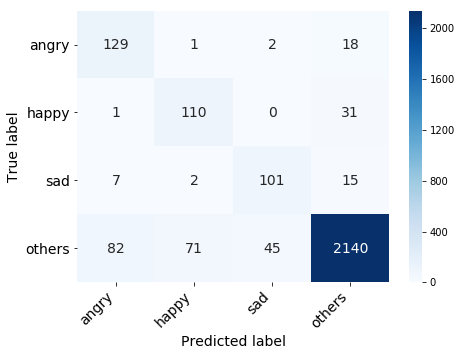

In [78]:
get_metrics(lreg_pred_sub.argmax(axis=1), to_categorical(labels, 4))

### Evaluating our model

In [ ]:
model, emb_matrix, word_index, model_metrics = load_model_full()

In [68]:
model = load_model('pickles/models/best.h5')

In [86]:
best_metrics = load_best_metrics(binary=False)

Best categorical model is acc_0.8980-f1_0.6945 with f1=0.6945


#### Test set

In [69]:
y_pred_test, proba_preds = get_predictions(model, X_test)
np.unique(y_pred_test)

array([0, 1, 2, 3])

True Positives per class :  [ 126.  106.  105. 2127.]
False Positives per class :  [84. 70. 68. 69.]
False Negatives per class :  [ 24.  36.  20. 211.]

Class angry : Precision : 0.600, Recall : 0.840, F1 : 0.700
Class happy : Precision : 0.602, Recall : 0.746, F1 : 0.667
Class sad : Precision : 0.607, Recall : 0.840, F1 : 0.705

Ignoring the Others class, Macro Precision : 0.6031, Macro Recall : 0.8088, Macro F1 : 0.6910
Ignoring the Others class, Micro TP : 337, FP : 222, FN : 80



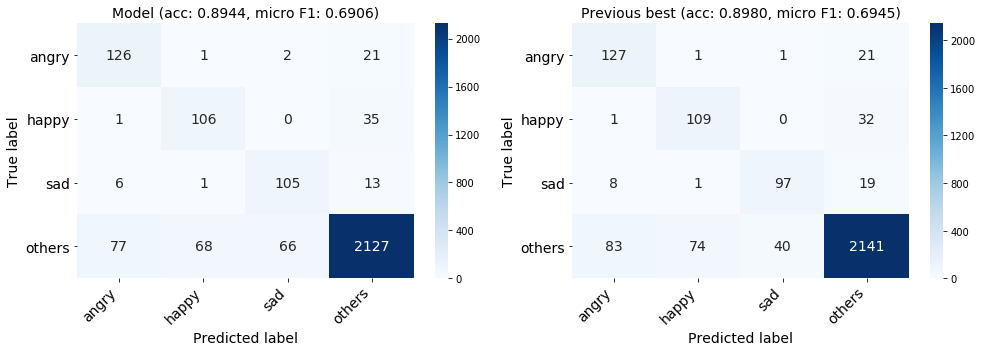

In [87]:
model_metrics = compare_metrics(proba_preds, y_test, best_metrics, binary_model=False)

In [73]:
save_model_full(model, emb_matrix, word_index, model_metrics)

Model saved at pickles/models/categorical/acc_0.8944-f1_0.6906/


### Generating a submission file

In [64]:
y_pred_sub = generate_predictions(model, 'data/test.txt', word_index=word_index)

Loading dataset...
Reading twitter - 1grams ...
Reading twitter - 2grams ...


Preprocessing...:   0%|          | 0/2755 [00:00<?, ?it/s]

Reading twitter - 1grams ...


Preprocessing...: 100%|██████████| 2755/2755 [00:00<00:00, 2928.88it/s]


Generating Predictions...
Done. Wrote submission.txt file at project's root
